In [25]:
import os
import timeit
from datetime import timedelta
from types import SimpleNamespace

import cdflib
import humanize
import matplotlib.pyplot as plt
import numpy as np
import pycdfpp
import requests
from spacepy import pycdf

In [52]:
def download_file(url):
    fname = url.split("/")[-1]
    if not os.path.exists(f"/tmp/cdfpp/{fname}"):
        with open(f"/tmp/cdfpp/{fname}", "wb") as f:
            print(f"downloading {url}")
            f.write(requests.get(url).content)
    return fname


def is_compressed(fname):
    return pycdfpp.load(fname).compression != pycdfpp.CDF_compression_type.no_compression
    


def file_size(fname):
    return os.stat(fname).st_size


urls = [
    "https://hephaistos.lpp.polytechnique.fr/data/mirrors/CDF/test_files/po_h9_pwi_1997010103_v01.cdf",
    #"https://hephaistos.lpp.polytechnique.fr/data/mirrors/CDF/test_files/bigcdf_compressed.cdf",
    "https://hephaistos.lpp.polytechnique.fr/data/mirrors/CDF/test_files/mms1_scm_srvy_l2_scsrvy_20190301_v2.2.0.cdf",
    "https://lasp.colorado.edu/mms/sdc/public/about/browse/mms1/edp/fast/l2/dce/2022/11/mms1_edp_fast_l2_dce_20221110_v3.0.0.cdf",
    "https://lasp.colorado.edu/mms/sdc/public/about/browse/mms1/fpi/fast/l2/des-dist/2022/11/mms1_fpi_fast_l2_des-dist_20221103060000_v3.4.0.cdf",
    "https://cdaweb.gsfc.nasa.gov/pub/data/solar-orbiter/rpw/science/l3/bia-efield/2022/solo_l3_rpw-bia-efield_20221118_v01.cdf",
    "https://cdaweb.gsfc.nasa.gov/pub/data/solar-orbiter/rpw/science/l3/bia-efield/2022/solo_l3_rpw-bia-efield_20221108_v01.cdf",
    "https://cdaweb.gsfc.nasa.gov/pub/data/solar-orbiter/rpw/science/l3/bia-efield/2022/solo_l3_rpw-bia-efield_20221027_v01.cdf",
    "https://cdaweb.gsfc.nasa.gov/pub/data/solar-orbiter/rpw/science/l3/bia-efield/2022/solo_l3_rpw-bia-efield_20221129_v01.cdf",
    "https://cdaweb.gsfc.nasa.gov/pub/data/solar-orbiter/rpw/science/l3/bia-efield/2022/solo_l3_rpw-bia-efield_20221023_v01.cdf",
    "https://cdaweb.gsfc.nasa.gov/pub/data/solar-orbiter/rpw/science/l3/bia-efield/2022/solo_l3_rpw-bia-efield_20221003_v01.cdf",
    "https://cdaweb.gsfc.nasa.gov/pub/data/solar-orbiter/rpw/science/l3/bia-efield/2022/solo_l3_rpw-bia-efield_20220906_v01.cdf",
]

cdf_corpus = list(map(lambda u: f"/tmp/cdfpp/{u.split('/')[-1]}", urls))

cdf_corpus_details = {
    fname: SimpleNamespace(size=file_size(fname),size_MB=file_size(fname)/1000**2, is_compressed=is_compressed(fname))
    for fname in cdf_corpus
}

In [46]:
list(map(download_file, urls))

['po_h9_pwi_1997010103_v01.cdf',
 'mms1_scm_srvy_l2_scsrvy_20190301_v2.2.0.cdf',
 'mms1_edp_fast_l2_dce_20221110_v3.0.0.cdf',
 'mms1_fpi_fast_l2_des-dist_20221103060000_v3.4.0.cdf',
 'solo_l3_rpw-bia-efield_20221118_v01.cdf',
 'solo_l3_rpw-bia-efield_20221108_v01.cdf',
 'solo_l3_rpw-bia-efield_20221027_v01.cdf',
 'solo_l3_rpw-bia-efield_20221129_v01.cdf',
 'solo_l3_rpw-bia-efield_20221023_v01.cdf',
 'solo_l3_rpw-bia-efield_20221003_v01.cdf',
 'solo_l3_rpw-bia-efield_20220906_v01.cdf']

In [47]:
class CdfLib:
    @staticmethod
    def just_open(fname):
        c = cdflib.CDF(fname)

    @staticmethod
    def list_variables(fname):
        c = cdflib.CDF(fname)
        cdf_info = c.cdf_info()
        variables = cdf_info.rVariables + cdf_info.zVariables

    @staticmethod
    def get_var_shape(fname, varname):
        shape = cdflib.CDF(fname).varinq(varname).Dim_Sizes

    @staticmethod
    def get_var_data(fname, varname, ntimes=1):
        c = cdflib.CDF(fname)
        for _ in range(ntimes):
            values = c.varget(varname)

    @staticmethod
    def full_load(fname):
        c = cdflib.CDF(fname)
        cdf_info = c.cdf_info()
        variables = cdf_info.rVariables + cdf_info.zVariables
        [c.varget(varname) for varname in variables if c.varinq(varname).Last_Rec != -1]


class SpacePy:
    @staticmethod
    def just_open(fname):
        c = pycdf.CDF(fname)

    @staticmethod
    def list_variables(fname):
        variables = list(pycdf.CDF(fname))

    @staticmethod
    def get_var_shape(fname, varname):
        shape = pycdf.CDF(fname)[varname].shape

    @staticmethod
    def get_var_data(fname, varname, ntimes=1):
        c = pycdf.CDF(fname)
        for _ in range(ntimes):
            values = c[varname][:]

    @staticmethod
    def full_load(fname):
        c = pycdf.CDF(fname)
        [c.raw_var(varname)[:] for varname in c if len(c.raw_var(varname).shape)]


class PyCdfPp:
    @staticmethod
    def just_open(fname):
        c = pycdfpp.load(fname)

    @staticmethod
    def list_variables(fname):
        variables = list(pycdfpp.load(fname))

    @staticmethod
    def get_var_shape(fname, varname):
        shape = pycdfpp.load(fname)[varname].shape

    @staticmethod
    def get_var_data(fname, varname, ntimes=1):
        c = pycdfpp.load(fname)
        for _ in range(ntimes):
            values = c[varname].values

    @staticmethod
    def full_load(fname):
        c = pycdfpp.load(fname)
        [c[varname].values for varname in c]


CDF_libs = {"CdfLib": CdfLib, "SpacePy": SpacePy, "PyCdfPp": PyCdfPp}

In [21]:
def bench_method(method, cdf_file, number=1000, **kwargs):
    return dict(
        sorted(
            [
                (
                    lib.__name__,
                    timeit.timeit(
                        lambda: getattr(lib, method)(cdf_file, **kwargs), number=number
                    )
                    / number,
                )
                for lib in (CdfLib, SpacePy, PyCdfPp)
            ],
            key=lambda item: item[1],
        )
    )

In [14]:
for file in cdf_corpus:
    print(f"{file}: {bench_method('just_open', file, number=10)}")

/tmp/cdfpp/po_h9_pwi_1997010103_v01.cdf: {'PyCdfPp': 0.00017465760001869057, 'CdfLib': 0.00019743439997910173, 'SpacePy': 0.0013674771999831136}
/tmp/cdfpp/bigcdf_compressed.cdf: {'PyCdfPp': 4.1726400013430975e-05, 'CdfLib': 9.148350000032224e-05, 'SpacePy': 0.006317985600071551}
/tmp/cdfpp/mms1_scm_srvy_l2_scsrvy_20190301_v2.2.0.cdf: {'PyCdfPp': 7.444359998771688e-05, 'CdfLib': 0.0001286544999857142, 'SpacePy': 0.07488809540000148}
/tmp/cdfpp/mms1_edp_fast_l2_dce_20221110_v3.0.0.cdf: {'CdfLib': 6.978670007811161e-05, 'PyCdfPp': 0.00016974700001810562, 'SpacePy': 0.35710396820004464}
/tmp/cdfpp/mms1_fpi_fast_l2_des-dist_20221103060000_v3.4.0.cdf: {'CdfLib': 7.033869997030706e-05, 'PyCdfPp': 0.00016071110003395005, 'SpacePy': 0.22939853950001635}
/tmp/cdfpp/solo_l3_rpw-bia-efield_20221118_v01.cdf: {'CdfLib': 7.315900002140552e-05, 'PyCdfPp': 0.00010246440006085322, 'SpacePy': 0.3560861213999488}
/tmp/cdfpp/solo_l3_rpw-bia-efield_20221108_v01.cdf: {'CdfLib': 7.064419996822835e-05, 'PyCdf

In [15]:
for file in cdf_corpus:
    print(f"{file}: {bench_method('list_variables', file, number=10)}")

/tmp/cdfpp/po_h9_pwi_1997010103_v01.cdf: {'PyCdfPp': 0.0004397436999170168, 'CdfLib': 0.0008901664000404708, 'SpacePy': 0.0019434917000580754}
/tmp/cdfpp/bigcdf_compressed.cdf: {'PyCdfPp': 4.000930002803216e-05, 'CdfLib': 0.00018436990003465326, 'SpacePy': 0.007342753300054028}
/tmp/cdfpp/mms1_scm_srvy_l2_scsrvy_20190301_v2.2.0.cdf: {'PyCdfPp': 9.068869994734995e-05, 'CdfLib': 0.000554038300015236, 'SpacePy': 0.07428468980006073}
/tmp/cdfpp/mms1_edp_fast_l2_dce_20221110_v3.0.0.cdf: {'PyCdfPp': 0.00019020620002265786, 'CdfLib': 0.0003931492999981856, 'SpacePy': 0.35737519610001983}
/tmp/cdfpp/mms1_fpi_fast_l2_des-dist_20221103060000_v3.4.0.cdf: {'PyCdfPp': 0.00019275120002930634, 'CdfLib': 0.000519059200087213, 'SpacePy': 0.23009514280001894}
/tmp/cdfpp/solo_l3_rpw-bia-efield_20221118_v01.cdf: {'PyCdfPp': 0.00011784670004999498, 'CdfLib': 0.0006292430999565113, 'SpacePy': 0.360084443300002}
/tmp/cdfpp/solo_l3_rpw-bia-efield_20221108_v01.cdf: {'PyCdfPp': 0.00010691139996197308, 'CdfLib':

In [9]:
bench_method(
    "get_var_shape",
    "/tmp/cdfpp/po_h9_pwi_1997010103_v01.cdf",
    varname="WBR_Elec",
    number=10000,
)

{'CdfLib': 0.00010431646050001291,
 'PyCdfPp': 0.00013730515209999793,
 'SpacePy': 0.000916535619699971}

In [10]:
bench_method(
    "get_var_data",
    "/tmp/cdfpp/po_h9_pwi_1997010103_v01.cdf",
    varname="WBR_Elec",
    number=10,
)

{'PyCdfPp': 0.3873259066000173,
 'SpacePy': 2.494506395299959,
 'CdfLib': 2.5678414205999616}

In [11]:
bench_method(
    "get_var_data",
    "/tmp/cdfpp/po_h9_pwi_1997010103_v01.cdf",
    varname="WBR_Elec",
    ntimes=3,
    number=2,
)

{'PyCdfPp': 0.40094440350003424,
 'CdfLib': 7.95899667499998,
 'SpacePy': 7.966956516499977}

In [48]:
times = {name: [] for name in CDF_libs}
sizes = [
    cdf_corpus_details[f].size / 1024**2
    for f in cdf_corpus
    if not cdf_corpus_details[f].is_compressed
]

for libname in times:
    for f in cdf_corpus:
        if not cdf_corpus_details[f].is_compressed:
            load = CDF_libs[libname].full_load
            t = timeit.timeit(lambda: load(f), number=10) / 10
            times[libname].append(t)


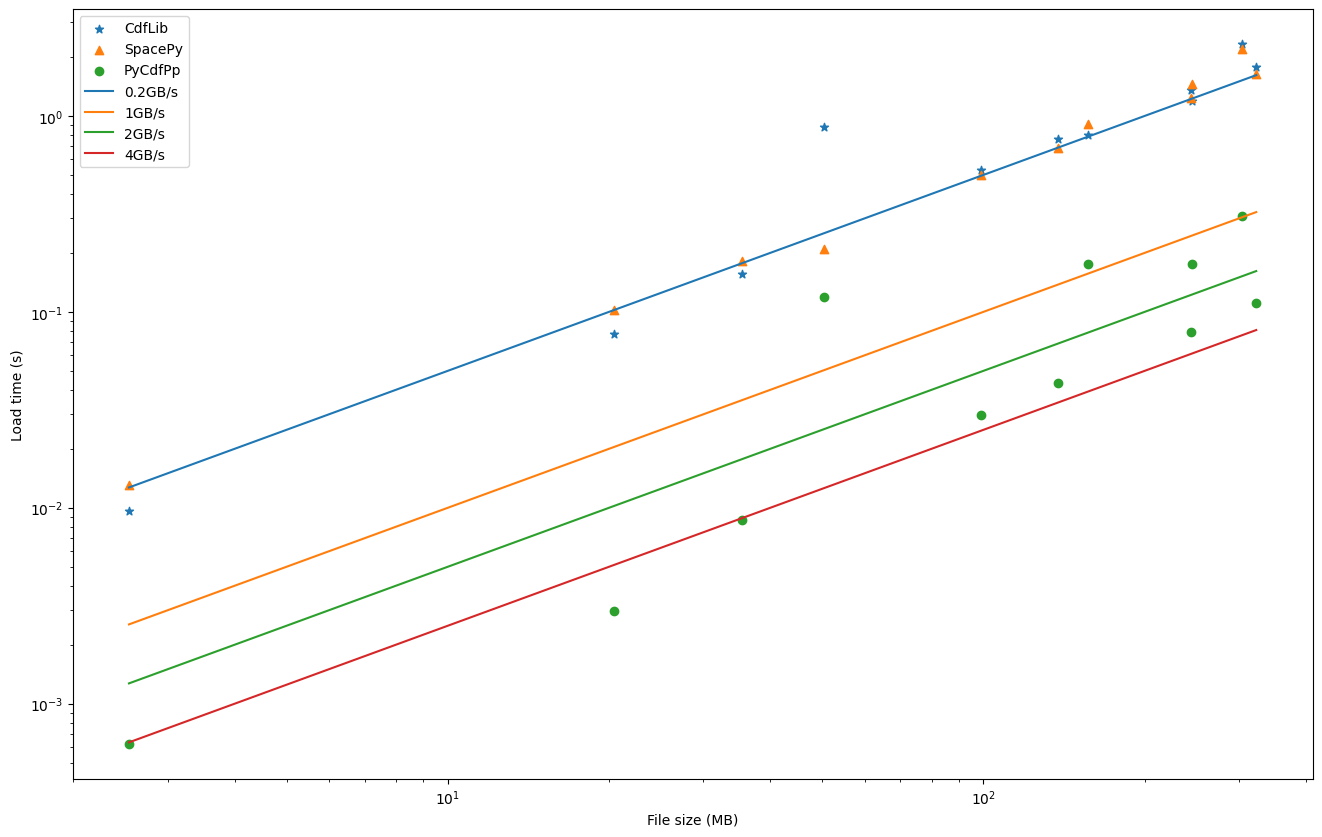

In [66]:
plt.figure(figsize=(16,10))
for marker,libname in zip(("*", "^", "o"), times):
    plt.scatter(sizes, times[libname], label=libname, marker=marker)
plt.plot(sorted(sizes), np.array(sorted(sizes)) / 200, label="0.2GB/s")
plt.plot(sorted(sizes), np.array(sorted(sizes)) / 1000, label="1GB/s")
plt.plot(sorted(sizes), np.array(sorted(sizes)) / 2000, label="2GB/s")
plt.plot(sorted(sizes), np.array(sorted(sizes)) / 4000, label="4GB/s")
plt.xlabel("File size (MB)")
plt.ylabel("Load time (s)")
plt.loglog()
plt.legend(loc="upper left")

In [33]:
cdflib.CDF("/tmp/cdfpp/po_h9_pwi_1997010103_v01.cdf").varinq("WBR_Mag")

VDRInfo(Variable='WBR_Mag', Num=12, Var_Type='rVariable', Data_Type=21, Data_Type_Description='CDF_REAL4', Num_Elements=1, Num_Dims=1, Dim_Sizes=[3984], Sparse='No_sparse', Last_Rec=-1, Rec_Vary=False, Dim_Vary=[True], Compress=1, Pad=array([-1.e+31], dtype=float32), Block_Factor=1)

In [14]:
pycdf.CDF("/tmp/cdfpp/po_h9_pwi_1997010103_v01.cdf")

<CDF:
DATA_MODE: CDF_BYTE [42506]
DATA_QUALITY: CDF_BYTE [42506, 3984]
Data_No: CDF_INT4 [3984] NRV
Delta_T: CDF_REAL8 [42506]
Epoch: CDF_EPOCH [42506]
FFT_size: CDF_INT4 [] NRV
FilterMode: CDF_BYTE [42506]
Gain1: CDF_BYTE [42506]
Gain2: CDF_BYTE [42506]
NumPoints: CDF_INT4 [42506]
Num_Snap: CDF_INT4 [] NRV
Sample_rate: CDF_REAL4 [42506]
Translation: CDF_INT4 [42506]
WBR_Ant: CDF_BYTE [42506]
WBR_Elec: CDF_REAL4 [42506, 3984]
WBR_Mag: CDF_REAL4 [3984] NRV
>

In [38]:
is_compressed('/tmp/cdfpp/bigcdf_compressed.cdf')

False

In [40]:
pycdfpp.load('/tmp/cdfpp/bigcdf_compressed.cdf').compression

<CDF_compression_type.no_compression: 0>

In [44]:
pycdf.CDF('/tmp/cdfpp/bigcdf_compressed.cdf')["temp"].compress()

(c_long(5), 5)

In [67]:
cdf_corpus_details

{'/tmp/cdfpp/po_h9_pwi_1997010103_v01.cdf': namespace(size=319220658,
           size_MB=319.220658,
           is_compressed=False),
 '/tmp/cdfpp/mms1_scm_srvy_l2_scsrvy_20190301_v2.2.0.cdf': namespace(size=52899085,
           size_MB=52.899085,
           is_compressed=False),
 '/tmp/cdfpp/mms1_edp_fast_l2_dce_20221110_v3.0.0.cdf': namespace(size=256553849,
           size_MB=256.553849,
           is_compressed=False),
 '/tmp/cdfpp/mms1_fpi_fast_l2_des-dist_20221103060000_v3.4.0.cdf': namespace(size=164276439,
           size_MB=164.276439,
           is_compressed=False),
 '/tmp/cdfpp/solo_l3_rpw-bia-efield_20221118_v01.cdf': namespace(size=255763922,
           size_MB=255.763922,
           is_compressed=False),
 '/tmp/cdfpp/solo_l3_rpw-bia-efield_20221108_v01.cdf': namespace(size=2663046,
           size_MB=2.663046,
           is_compressed=False),
 '/tmp/cdfpp/solo_l3_rpw-bia-efield_20221027_v01.cdf': namespace(size=21423469,
           size_MB=21.423469,
           is_compre

In [19]:
pycdf.CDF("/tmp/cdfpp/po_h9_pwi_1997010103_v01.cdf").raw_var("WBR_Mag").shape

(3984,)

In [48]:
pycdf.CDF("/tmp/cdfpp/po_h9_pwi_1997010103_v01.cdf")["Data_No"][:]

array([   0,    1,    2, ..., 3981, 3982, 3983], dtype=int32)

In [23]:
pycdfpp.load("/tmp/cdfpp/po_h9_pwi_1997010103_v01.cdf").compression

<CDF_compression_type.no_compression: 0>

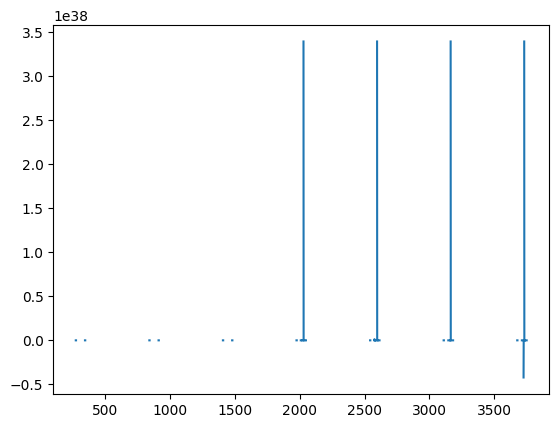

In [46]:
plt.figure()
plt.plot(pycdfpp.load("/tmp/cdfpp/po_h9_pwi_1997010103_v01.cdf")["WBR_Mag"].values[0])

In [13]:
for f in cdf_corpus:
    print(f)
    SpacePy.full_load(f)

/tmp/cdfpp/po_h9_pwi_1997010103_v01.cdf


IndexError: Slice does not match dimensions for zVar b'Num_Snap'